In [ ]:
import numpy as np
from numpy.linalg import svd, norm, eigh
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from itertools import product
from statsmodels.tools.eval_measures import bic
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [117]:
url = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64"

df = pd.read_csv(url)

In [51]:
# Define transformation functions according to FRED-MD specifications
def identity(x: pd.Series) -> pd.Series:
    return x

def lag1(x: pd.Series) -> pd.Series:
    return x.shift(1)

def diff(x: pd.Series) -> pd.Series:
    return x.diff()

def diff2(x: pd.Series) -> pd.Series:
    return x.diff().diff()

def logdiff(x: pd.Series) -> pd.Series:
    return np.log(x) - np.log(x.shift(1))

def logdiff2(x: pd.Series) -> pd.Series:
    return (np.log(x) - np.log(x.shift(1))).diff()

def diffp(x: pd.Series) -> pd.Series:
    return ((x / x.shift(1)) - 1).diff()

def logd(x: pd.Series) -> pd.Series:
    x = x.copy()
    x[x <= 0] = np.nan
    return np.log(x)


# Create a tuple of transformation functions indexed by tcode
tfuns = [identity, diff, diff2, logd, logdiff, logdiff2, diffp]

In [82]:
def df_cleaning(df):
    df_onlydata = df.iloc[1:-1].copy()
    df_onlydata['sasdate'] = pd.to_datetime(df_onlydata['sasdate'], format='%m/%d/%Y')
    df_onlydata = df_onlydata[
        (df_onlydata['sasdate'] >= pd.Timestamp(1960, 1, 1)) &
        (df_onlydata['sasdate'] <= pd.Timestamp(2025, 3, 1))
    ]

    # Extract transformation codes and convert to int - 1
    tcode = df.iloc[0, 1:].astype(float) - 1  # exclude 'sasdate' column

    for i, col in enumerate(df_onlydata.columns[1:]):  # skip 'sasdate'
        trcode = int(tcode.iloc[i])
        if 0 <= trcode < len(tfuns):
            df_onlydata[col] = tfuns[trcode](df_onlydata[col])
        else:
            raise ValueError(f"Invalid transformation code {trcode} for column {col}")

    return df_onlydata.reset_index(drop=True).iloc[2:-1,:], tcode


fredmd, tcode = df_cleaning(df)

In [83]:
fredmd

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
2,1960-03-01,0.001877,0.000905,0.014089,-0.028040,-0.001102,-0.009021,-0.003427,-0.001151,0.001151,...,0.001791,-0.001146,-0.000020,0.030131,-0.004684,NaN,0.003472,0.000951,0.003490,NaN
3,1960-04-01,0.003465,0.003612,0.015302,0.009853,0.025903,-0.007956,0.002286,0.001151,0.006882,...,0.004424,0.001523,-0.008949,-0.068074,0.000000,NaN,0.008678,0.005452,0.024136,NaN
4,1960-05-01,0.002405,0.002427,-0.020351,-0.031518,-0.015047,-0.001143,0.005692,0.006865,0.005696,...,-0.006700,0.000565,0.008949,0.041620,0.000000,NaN,-0.004827,-0.002067,0.003798,NaN
5,1960-06-01,0.000764,-0.000235,-0.000250,0.008553,-0.001364,-0.012652,-0.011413,-0.011467,-0.006839,...,0.000215,-0.000764,-0.004474,-0.011429,0.000000,NaN,0.005126,0.007420,-0.009981,NaN
6,1960-07-01,0.001791,0.001914,0.002061,-0.006866,-0.010099,-0.003481,-0.005758,-0.005785,-0.009196,...,0.001778,0.000563,0.004454,0.007547,0.000000,NaN,-0.010926,-0.003291,0.032176,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,2024-10-01,0.004246,0.004663,0.001322,-0.001849,0.006428,-0.003726,-0.008061,-0.010812,-0.005803,...,0.003609,0.000727,-0.003839,-0.005006,-0.002154,0.4,-0.000203,0.001703,-0.000679,19.9478
778,2024-11-01,0.002384,0.003228,0.004463,0.004270,0.006384,-0.002581,-0.002617,-0.002286,-0.006625,...,0.000117,-0.002130,-0.000639,-0.002760,0.003190,1.3,-0.000872,-0.001684,-0.011910,15.9822
779,2024-12-01,0.001096,0.001370,0.005548,0.008358,0.007717,0.010945,0.010944,0.010929,0.007675,...,0.004218,0.002179,0.002206,0.004953,-0.001439,2.2,0.004047,0.004152,0.002077,15.6997
780,2025-01-01,0.001877,-0.000061,-0.004536,-0.009680,-0.008678,0.001365,0.005324,0.006178,0.004423,...,0.001618,-0.000851,0.001865,-0.001115,0.004895,-2.3,-0.005405,-0.003554,-0.000556,16.8122


In [84]:
def mark_outliers_as_missing(df:pd.DataFrame, k:int = 10.0):
    """
    Identifies and marks extreme outliers in a DataFrame as missing (NaN) values.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing numeric columns and a 'sasdate' column (which is excluded).
        k (int or float, optional): Multiplier for the IQR-based outlier detection threshold. 
                                    Observations more than k * IQR away from the median are marked as NaN. 
                                    Default is 10.0.

    Returns:
        pd.DataFrame: Modified DataFrame with extreme outliers replaced by NaN in each column except 'sasdate'.

    Notes:
        - Outliers are defined as values that differ from the median by more than k times the interquartile range (IQR).
        - The function operates column-wise and skips NaN values when computing statistics.
    """
    df_copy = df.copy()
    for col in df.columns.drop('sasdate'):
        x = df[col]
        xclean = x.dropna()
        q25, median, q75 = xclean.quantile([0.25, 0.5, 0.75])
        iqr = q75 - q25
        threshold = k * iqr
        mask = (x - median).abs() >= threshold
        df.loc[mask, col] = np.nan
    number_of_outliers_removed = df.isna().sum().sum() - df_copy.isna().sum().sum() 
    print(f'Removed {number_of_outliers_removed} outliers')
    return df

fredmd_nooutliers = mark_outliers_as_missing(fredmd)


Removed 157 outliers


In [85]:
def pc2(X,nfac):
    '''' =========================================================================
     DESCRIPTION
     This function runs principal component analysis.

     -------------------------------------------------------------------------
     INPUTS
               X      = dataset (one series per column)
               nfac   = number of factors to be selected

     OUTPUTS
               chat  f = values of X predicted by the factors
               fhat   = factors scaled by (1/sqrt(N)) where N is the number of
                        series
               lambda = factor loadings scaled by number of series
               ss     = eigenvalues of X'*X

     ========================================================================= '''

    N = X.shape[1]  # Number of series in X (i.e. number of columns)
    # The rows of vh are the eigenvectors of A'A and the columns of u are the eigenvectors of AA'.
    # In both cases the corresponding (possibly non-zero) eigenvalues are given by s**2.
    U, S, Vh = np.linalg.svd(X.T@X) # Singular value decomposition: X'*X = U*S*V where V=U'

    lambda_ = U[:, :nfac]*np.sqrt(N)   # Factor loadings scaled by sqrt(N)
    fhat = np.dot(X, lambda_)*(1/N)  # Factors scaled by 1/sqrt(N) (note that lambda is scaled by sqrt(N))
    chat = np.dot(fhat, lambda_.T) # Estimate initial dataset X using the factors (note that U'=inv(U))
    ss = S                          #  a vector of singular values of X'*X, eigenvalues are ss**2??

    return chat, fhat, lambda_, ss

In [ ]:
def pca_em_missing(df: pd.DataFrame, r: int, max_iter: int = 1000, tol: float = 1e-6):
    """
    PCA with EM algorithm to handle missing values (Stock and Watson, 2002).

    Parameters:
        df: pandas DataFrame with a 'sasdate' column and other numeric columns (some may have NaNs).
        r: number of static factors.
        max_iter: max number of EM iterations.
        tol: relative convergence tolerance for factors.

    Returns:
        F: T x r matrix of estimated factors (standardized)
        Lambda: N x r matrix of factor loadings (standardized)
        X_completed: T x N DataFrame with missing values imputed (in original scale)
    """

    # Check that x is not missing values for an entire row
    assert (df.isna().sum(axis=1) == df.shape[1]).sum() == 0, 'X contains entire rows of missing values'

    # Check that x is not missing values for an entire column
    assert (df.isna().sum(axis=0) == df.shape[0]).sum() == 0, 'X contains entire columns of missing values'

    # Separate date and data columns
    date_col = df['sasdate'].reset_index(drop=True) #crea una serie con solo le date, droppa l'indice
    X_raw = df.drop(columns=['sasdate']).to_numpy() #X è il df senza le date
    
    T, N = X_raw.shape #T = numero di righe, N = numero di colonne
    
    mask = ~np.isnan(X_raw) #Una maschera con true dove non ci sono i NaN


    # Initial mean and std ignoring NaNs
    mu = np.nanmean(X_raw, axis=0) #fa la media per colonna ignorando i NaN
    sigma = np.nanstd(X_raw, axis=0) #fa la st.dev pre colonna ignorando i Nan
    #-------------------------------------------------------------------------------------
    #sigma[sigma == 0] = 1.0  # Avoid division by zero ///Impone una st.dev di 1 se è 0////
    #-------------------------------------------------------------------------------------

    # Standardize and initialize missing with zero
    X_std = (X_raw - mu) / sigma #crea un nuovo df con le colonne standardizzate
    X_std[np.isnan(X_std)] = 0 #mette 0 al posto dei NaN


    #inizializza F
    F_old = np.zeros((T, r)) #crea un array con tutti 0 di T righe(numero di righe di X) e r colonne(numero di fattori richiesto)

    for iteration in range(max_iter):
        # PCA via SVD
        X_hat, F_new, Lambda,ss = pc2(X_std,r) #

        X_completed = X_raw.copy() #copia X_raw
        X_completed[~mask] = X_hat[~mask] #Mette i valori simulati su X completed dove prima c'erano i NaN

        # Recompute standardization stats
        mu = np.mean(X_completed, axis=0)
        sigma = np.std(X_completed, axis=0)
        sigma[sigma == 0] = 1.0
        X_std = (X_completed - mu) / sigma #Standardizza di nuovo aggiornando X_std con i nuovi valori simulati

        F_old = F_new #Aggiorna F

    # Return completed DataFrame with 'sasdate'
    completed_df = pd.DataFrame(X_completed, columns=df.columns.drop('sasdate'))
    completed_df.insert(0, 'sasdate', date_col)
    #completed_df.fillna(0, inplace=True)  # Safety

    return F_old, Lambda, completed_df


In [125]:
F, Lambda, completed_df = pca_em_missing(fredmd_nooutliers, 8)

In [108]:
completed_df.isna().sum().sum() 

np.int64(0)

In [126]:
def plot_factors(F: np.ndarray, dates: pd.Series):
    """
    Plot estimated factors over time.

    Parameters:
        F: T x r matrix of estimated factors
        dates: pd.Series of datetime values (e.g., from 'sasdate' column)
    """
    r = F.shape[1]
    plt.figure(figsize=(12, r * 2.5))
    for i in range(r):
        plt.subplot(r, 1, i + 1)
        plt.plot(dates, F[:, i])
        plt.title(f'Factor {i + 1}')
        plt.tight_layout()
    plt.show()


In [ ]:
dates = completed_df['sasdate']
plot_factors(F, dates)

In [114]:
F.shape[0]

780

In [115]:
# Step 1: Estrai i dati numerici (senza la colonna 'sasdate')
X = completed_df.drop(columns=['sasdate'])
T, N = X.shape
r = F.shape[1] 

# Step 2: Calcola R² per ogni serie su ciascun fattore (uno alla volta)
r2_table = {f'Factor {j+1}': {} for j in range(r)}

for col in X.columns:
    y = X[col].values.reshape(-1, 1)
    for j in range(r):
        x = F[:, j].reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        r2_table[f'Factor {j+1}'][col] = r2

# Step 3: Costruisci la tabella dei top 10 per ciascun fattore
top_r2_df = pd.DataFrame()
for factor, scores in r2_table.items():
    top_series = sorted(scores.items(), key=lambda x: -x[1])[:10]
    series_names, r2_values = zip(*top_series)
    top_r2_df[f'{factor} - Series'] = series_names
    top_r2_df[f'{factor} - R²'] = r2_values

print("🔟 Top 10 series per factor:\n")
print(top_r2_df.to_string(index=False))

# ✅ Step 4: Calcola la media R² per ciascun fattore (mR²)
mean_r2 = {}
for j in range(r):
    r2s = []
    for col in X.columns:
        y = X[col].values.reshape(-1, 1)
        x = F[:, j].reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        r2s.append(model.score(x, y))
    mean_r2[f'Factor {j+1}'] = np.mean(r2s)

# Tabella dei mR²
mR2_df = pd.DataFrame.from_dict(mean_r2, orient='index', columns=['mR²'])
mR2_df.index.name = 'Factor'

print("\n📊 Mean R² per Factor (mR²):")
print(mR2_df.round(4))


🔟 Top 10 series per factor:

Factor 1 - Series  Factor 1 - R² Factor 2 - Series  Factor 2 - R² Factor 3 - Series  Factor 3 - R² Factor 4 - Series  Factor 4 - R² Factor 5 - Series  Factor 5 - R² Factor 6 - Series  Factor 6 - R² Factor 7 - Series  Factor 7 - R² Factor 8 - Series  Factor 8 - R²
         IPDCONGD       0.996990       CUSR0000SAC       0.644862             HOUST       0.636207            T1YFFM       0.806643               GS5       0.572504              M1SL       0.830507     TWEXAFEGSMTHx       0.622131         NONBORRES       0.491973
           IPDMAT       0.996777     CUSR0000SA0L2       0.635200            PERMIT       0.560669          TB6SMFFM       0.801301               GS1       0.561142          BUSLOANS       0.829527           ANDENOx       0.592961          TOTRESNS       0.473952
         ISRATIOx       0.996669          CPIAUCSL       0.617051           PERMITW       0.525594            T5YFFM       0.772294             TB6MS       0.530217          BOGMB

# Forecast

In [301]:
model = sm.tsa.DynamicFactorMQ(
    endog=completed_df.drop(columns = 'sasdate'),  
    factors=8
)

In [302]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of observed variables:                   126
                   + 8 factors in 8 blocks   # of factor blocks:                          8
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                                  0   Standardize variables:                    True
                                     - 780                                                 
                                   Observed variables / factor loadings                                  
=========================================================================================================
  Dep. variable          0          1          2           3           4          5          6          7
---------------------------------------------------------------------------------------------------------
            RPI          X          X          X           X           X          X          X          X
        W875RX1          X          X          X           X           X          X          X          X
DPCERA3M086SBEA          X          X          X           X           X          X          X          X
      CMRMTSPLx          X          X          X           X           X          X          X          X
        RETAILx          X          X          X           X           X          X          X          X
         INDPRO          X          X          X           X           X          X          X          X
        IPFPNSS          X          X          X           X           X          X          X          X
        IPFINAL          X          X          X           X           X          X          X          X
        IPCONGD          X          X          X           X           X          X          X          X
       IPDCONGD          X          X          X           X           X          X          X          X
       IPNCONGD          X          X          X           X           X          X          X          X
        IPBUSEQ          X          X          X           X           X          X          X          X
          IPMAT          X          X          X           X           X          X          X          X
         IPDMAT          X          X          X           X           X          X          X          X
         IPNMAT          X          X          X           X           X          X          X          X
      IPMANSICS          X          X          X           X           X          X          X          X
      IPB51222S          X          X          X           X           X          X          X          X
        IPFUELS          X          X          X           X           X          X          X          X
         CUMFNS          X          X          X           X           X          X          X          X
            HWI          X          X          X           X           X          X          X          X
      HWIURATIO          X          X          X           X           X          X          X          X
        CLF16OV          X          X          X           X           X          X          X          X
         CE16OV          X          X          X           X           X          X          X          X
         UNRATE          X          X          X           X           X          X          X          X
       UEMPMEAN          X          X          X           X           X          X          X          X
        UEMPLT5          X          X          X           X           X          X          X          X
      UEMP5TO14          X          X          X           X           X          X          X          X
       UEMP15OV       

In [223]:
results = model.fit(disp=10)

EM start iterations, llf=20923
EM iteration 10, llf=34024, convergence criterion=0.00042605
EM iteration 20, llf=34063, convergence criterion=3.1956e-05
EM iteration 30, llf=34069, convergence criterion=9.1273e-06
EM iteration 40, llf=34071, convergence criterion=4.5904e-06
EM iteration 50, llf=34072, convergence criterion=2.8501e-06
EM iteration 60, llf=34073, convergence criterion=1.9517e-06
EM iteration 70, llf=34073, convergence criterion=1.4177e-06
EM iteration 80, llf=34074, convergence criterion=1.0731e-06
EM converged at iteration 83, llf=34074, convergence criterion=9.9349e-07 < tolerance=1e-06


In [224]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:         "RPI", and 125 more   No. Observations:                  780
Model:                Dynamic Factor Model   Log Likelihood               34073.928
                   + 8 factors in 8 blocks   AIC                         -65595.855
                     + AR(1) idiosyncratic   BIC                         -59650.596
Date:                     Sat, 14 Jun 2025   HQIC                        -63309.229
Time:                             13:26:23   EM Iterations                       83
Sample:                                  0                                         
                                     - 780                                         
Covariance Type:              Not computed                                         
                                                            Observation equation:                                                             
==============================================================================================================================================
Factor loadings:          0          1          2           3           4          5          6          7    idiosyncratic: AR(1)        var.
----------------------------------------------------------------------------------------------------------------------------------------------
             RPI       0.16       0.01      -0.01       -0.01        0.01       0.00       0.00       0.00                   -0.20        0.00
         W875RX1       0.16       0.01       0.00       -0.00       -0.00      -0.00      -0.00      -0.00                   -0.13        0.00
 DPCERA3M086SBEA       0.16       0.01      -0.01       -0.01        0.01       0.00       0.00       0.00                   -0.10        0.00
       CMRMTSPLx       0.16       0.01       0.00        0.00       -0.00       0.00       0.00      -0.00                   -0.39        0.00
         RETAILx       0.16       0.01      -0.01       -0.01        0.01       0.00       0.00       0.00                   -0.20        0.00
          INDPRO       0.16       0.01       0.00       -0.00       -0.00       0.00       0.00      -0.00                   -0.26        0.00
         IPFPNSS       0.16       0.01       0.00       -0.00       -0.00       0.00       0.00      -0.00                   -0.29        0.00
         IPFINAL       0.16       0.01       0.00       -0.00       -0.00       0.00       0.00      -0.00                   -0.24        0.00
         IPCONGD       0.16       0.01       0.00        0.00       -0.00       0.00       0.00      -0.00                   -0.19        0.00
        IPDCONGD       0.16       0.01       0.00        0.00       -0.00       0.00       0.00       0.00                   -0.18        0.00
        IPNCONGD       0.04      -0.05      -0.01        0.03       -0.02       0.06       0.06      -0.02                   -0.23        0.79
         IPBUSEQ       0.16       0.01       0.00        0.00       -0.00       0.00       0.00      -0.00                    0.03        0.00
           IPMAT       0.16       0.01       0.00       -0.00       -0.00       0.00       0.00      -0.00                   -0.11        0.00
          IPDMAT       0.16       0.01       0.00       -0.00       -0.00       0.00       0.00      -0.00                    0.15        0.00
          IPNMAT       0.05      -0.08      -0.04       -0.00       -0.05       0.01       0.04      -0.02                   -0.09        0.61
       IPMANSICS       0.16       0.01       0.00       -0.00       -0.00       0.00       0.00      -0.00                   -0.27        0.00
       IPB51222S      -0.02       0.01       0.02       -0.01        0.00       0.04       0.04       0.02                   -0.19        0.98
         IPFUELS       0.

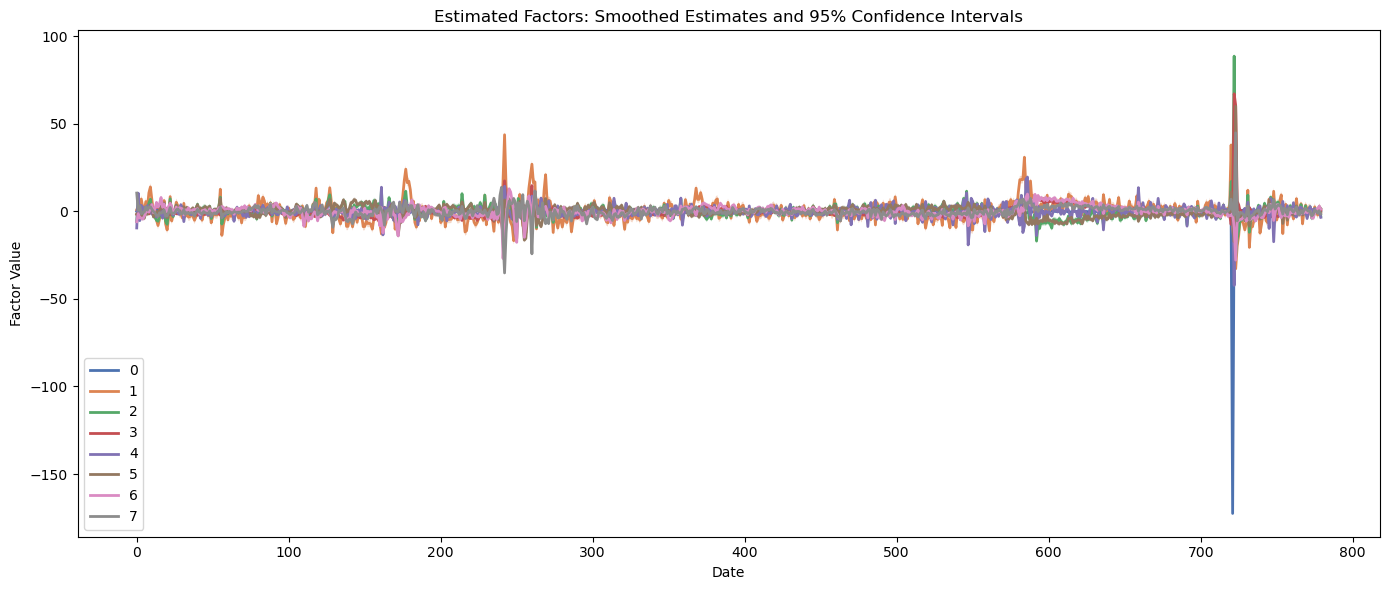

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm

# 1. Factor names
factor_names = [f'{i}' for i in range(8)]

# 2. Get smoothed factor estimates
mean = results.factors.smoothed[factor_names]

# 3. Get standard deviations from the diagonal of the smoothed covariance matrix
std = pd.concat([
    np.sqrt(results.factors.smoothed_cov.loc[name, name])
    for name in factor_names
], axis=1)
std.columns = factor_names

# 4. Compute 95% confidence intervals
crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

# 5. Plot
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))
    mean.plot(ax=ax, legend=True, lw=2)

    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)

    ax.set_title('Estimated Factors: Smoothed Estimates and 95% Confidence Intervals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Factor Value')
    fig.tight_layout()
    plt.show()


In [234]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by 0           Top ten variables explained by 1  \
                          Variable     $R^2$                         Variable   
0                         IPDCONGD  0.997075                           CUMFNS   
1                           IPDMAT  0.996676                           PERMIT   
2                         ISRATIOx  0.996448                         FEDFUNDS   
3                          IPBUSEQ  0.996388                            HOUST   
4                        IPMANSICS  0.996386                           IPNMAT   
5                            IPMAT  0.996290                           HOUSTS   
6                           INDPRO  0.996259                          PERMITW   
7                          IPFINAL  0.996231                            TB3MS   
8                          IPFPNSS  0.996211                           HOUSTW   
9                          IPCONGD  0.996190                            TB6MS   

            Top ten variables explained by 2            \
      $R^2$                         Variable     $R^2$   
0  0.225270                        OILPRICEx  0.443143   
1  0.221656                         BOGMBASE  0.430007   
2  0.221341                             M1SL  0.397465   
3  0.215337                         BUSLOANS  0.380213   
4  0.200315                       WPSFD49502  0.148246   
5  0.190230                       WPSFD49207  0.132286   
6  0.188082                      CUSR0000SAC  0.114946   
7  0.186595                    CUSR0000SA0L2  0.109242   
8  0.184988                         CPITRNSL  0.104162   
9  0.183486                         CPIAUCSL  0.098266   

  Top ten variables explained by 3           Top ten variables explained by 4  \
                          Variable     $R^2$                         Variable   
0                         BUSLOANS  0.438498                  DNDGRG3M086SBEA   
1                             M1SL  0.432453                      CUSR0000SAC   
2                         BOGMBASE  0.365885                    CUSR0000SA0L2   
3                        OILPRICEx  0.354367                         CPIAUCSL   
4                            HOUST  0.213899                    CUSR0000SA0L5   
5                          PERMITW  0.190271                         CPITRNSL   
6                           PERMIT  0.189187                            PCEPI   
7                           HOUSTW  0.180018                         CPIULFSL   
8                         PERMITMW  0.167460                          WPSID61   
9                           HOUSTS  0.165505                         BOGMBASE   

            Top ten variables explained by 5            \
      $R^2$                         Variable     $R^2$   
0  0.531757                            HOUST  0.216442   
1  0.504612                           PERMIT  0.197667   
2  0.488561                         PERMITMW  0.193877   
3  0.447666                          PERMITW  0.191847   
4  0.432977                           HOUSTW  0.184769   
5  0.420410                          HOUSTMW  0.166821   
6  0.368382                         PERMITNE  0.165991   
7  0.349749                           HOUSTS  0.156768   
8  0.178442                           T1YFFM  0.146408   
9  0.146039                          HOUSTNE  0.131418   

  Top ten variables explained by 6           Top ten variables explained by 7  \
                          Variable     $R^2$                         Variable   
0                           T1YFFM  0.272632                              GS1   
1                         TB6SMFFM  0.257716                            TB6MS   
2                         TB3SMFFM  0.242472                            TB3MS   
3                          T10YFFM  0.241832                              GS5   
4                           T5YFFM  0.241552                              AAA   
5                            HOUST  0.212218                             GS10   
6             

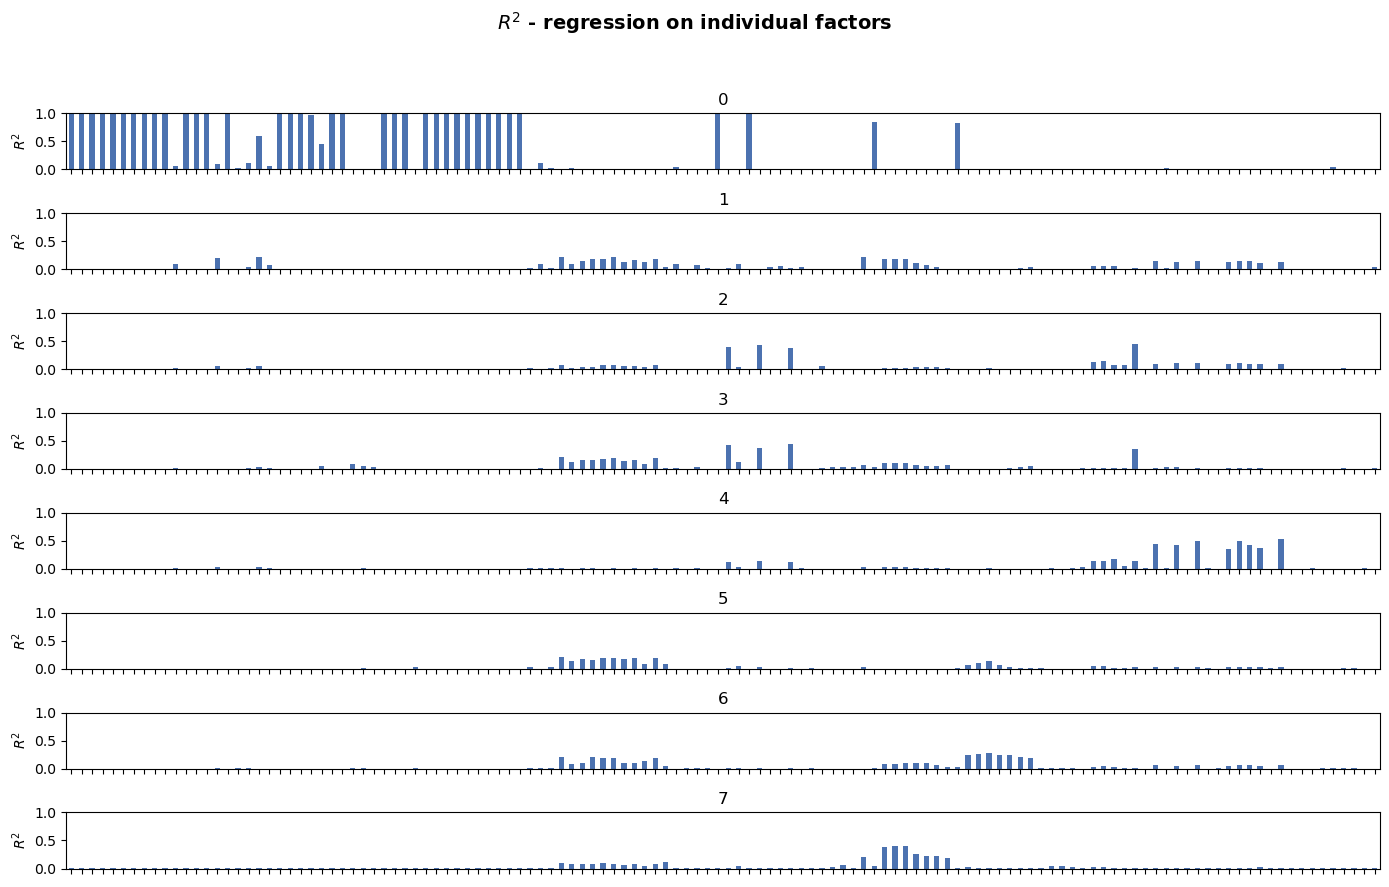

In [235]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

# Forecast 

In [243]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts[['INDPRO','CPIAUCSL']])

       INDPRO  CPIAUCSL
780 -0.034980  0.000799
781 -0.033994 -0.000178
782 -0.033904  0.000166


In [244]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=6)

# Print the forecasts for the first 5 observed variables
print(point_forecasts[['INDPRO','CPIAUCSL']])

       INDPRO  CPIAUCSL
780 -0.034980  0.000799
781 -0.033994 -0.000178
782 -0.033904  0.000166
783 -0.033724 -0.000023
784 -0.033686  0.000047
785 -0.033664 -0.000003


In [ ]:
forecast_list = []
forecast = (df['INDPRO'][-1:]).values[0] + np.exp((point_forecasts['INDPRO'][:1]).values[0]) 
forecast_list.append(forecast)
print(f'forecast at t+1 is {forecast}')
for i in range(1,6):
    forecast = (df['INDPRO'][-i-1:-i]).values[0] + np.exp((point_forecasts['INDPRO'][i:i+1]).values[0]) 
    forecast_list.append(forecast)
    print(f'forecast at t+{i+1} is {forecast}')


forecast at t+1 is 104.84552466521664
forecast at t+2 is 104.85307773679106
forecast at t+3 is 105.11566419813853
forecast at t+4 is 104.17993793679747
forecast at t+5 is 104.03917481198289
forecast at t+6 is 102.91719642378325


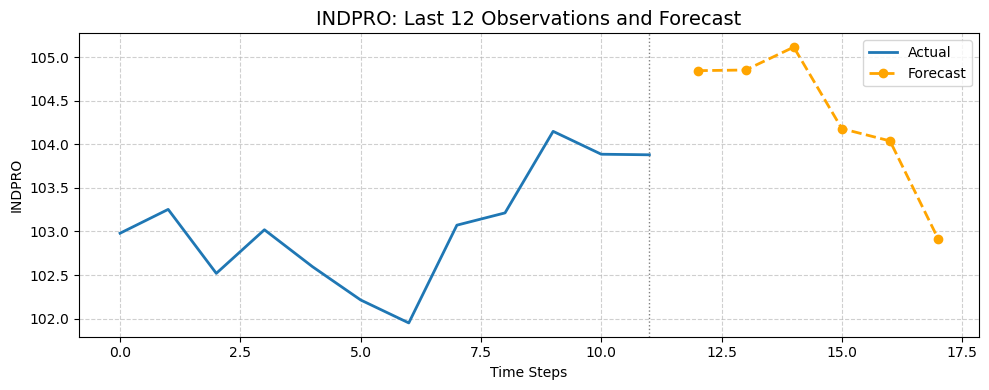

In [298]:
# Last 12 actual values
s = df['INDPRO'][-12:]
s.index = range(len(s))  # reset index to align with forecast

# Forecast values
forecasted_values = pd.Series(forecast_list, index=range(len(s), len(s) + len(forecast_list)))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(s, label='Actual', linewidth=2)
plt.plot(forecast, label='Forecast', color='orange', linestyle='--', linewidth=2, marker='o')

# Highlight the last real value
plt.axvline(x=len(s) - 1, color='gray', linestyle=':', linewidth=1)

plt.title('INDPRO: Last 12 Observations and Forecast', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('INDPRO')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [336]:
def compute_xt(forecast: float, x_tm1: float, x_tm2: float) -> float:
    """
    Computes x_t from the formula:
        x_t = exp(a) * (x_{t-1} ** 2) / x_{t-2}

    Parameters:
        forecast: the value of a (scalar)
        x_tm1: x_{t-1}
        x_tm2: x_{t-2}

    Returns:
        x_t
    """
    return np.exp(forecast) * (x_tm1 ** 2) / x_tm2

In [347]:
list(point_forecasts['INDPRO'].values)

[np.float64(-0.03498006559730987),
 np.float64(-0.03399355233064184),
 np.float64(-0.03390410532873088),
 np.float64(-0.03372439137211184),
 np.float64(-0.03368625211337706),
 np.float64(-0.033663900141263435)]

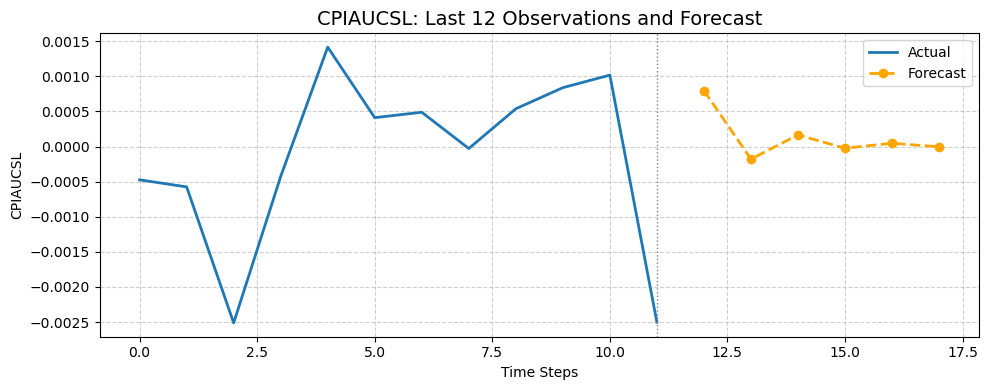

In [349]:
# --- Data prep -------------------------------------------------------------
s = completed_df['CPIAUCSL'].iloc[-12:]             # last 12 actual values
s.index = range(len(s))                   # 0 … 11
forecast_list_cpi = list(point_forecasts['CPIAUCSL'].values)
forecasted_values = pd.Series(
    forecast_list_cpi,
    index=range(len(s), len(s) + len(forecast_list_cpi))  # 12 … 17
)

# --- Plot ------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(s, label='Actual', linewidth=2)
plt.plot(forecasted_values, label='Forecast', color='orange',
         linestyle='--', linewidth=2, marker='o')

plt.axvline(x=len(s) - 1, color='gray', linestyle=':', linewidth=1)  # divider
plt.title('CPIAUCSL: Last 12 Observations and Forecast', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('CPIAUCSL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Rolling window forecast

In [355]:
def simple_rolling_forecast(df, target, factors=8, window=600, h=1):
    """
    Simple rolling forecast with DynamicFactorMQ.
    
    df: DataFrame with monthly data (including 'sasdate' and target series)
    target: column name to forecast
    factors: number of factors
    window: number of observations per rolling window
    h: forecast horizon (e.g., 1 = one-step-ahead)
    """
    forecasts = []
    actuals = []
    dates = []
    max_iter = 10

    df = df.dropna().reset_index(drop=True)
    count = 0
    for i in range(window, len(df) - h):
        if count >= max_iter:
            break
        train = df.iloc[i - window:i]
        test = df.iloc[i + h - 1]

        model = sm.tsa.DynamicFactorMQ(
            endog=train.drop(columns=['sasdate']),
            factors=factors
        )
        res = model.fit(disp=False)
        fcast = res.forecast(steps=h).iloc[-1][target]

        forecasts.append(fcast)
        actuals.append(test[target])
        dates.append(test['sasdate'])
        count += 1

    return pd.DataFrame({
        'sasdate': dates,
        'forecast': forecasts,
        'actual': actuals
    })

In [ ]:
simple_rolling_forecast(completed_df,'INDPRO',)